In [59]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
# setup
batch_size = 3
steps_per_epoch = int(12525/batch_size) + 1
validation_steps = int(3454/batch_size) + 1

In [39]:
### Model building ####

base_model = ResNet50(
            include_top=False,
            input_shape=(224, 224, 3),
            weights='imagenet')

#add a new dense layer to the end of the network inplace of the old layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# add the outplut layer
predictions = Dense(44, activation='softmax')(x)

# create new model composed of pre-trained network and new final layers
model = Model(input=base_model.input, output=predictions)

# we only train on the fully connected layers (the last two layers)
for layer in model.layers[:-2]:
    layer.trainable = False

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [40]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [41]:
# compile model
model.compile(loss='categorical_crossentropy',
            optimizer='sgd',
            metrics=['accuracy'])


In [42]:
train_dir = "../images/images_genus/train/"
val_dir = "../images/images_genus/val/"

In [43]:
labels = getLabelsFromDir(train_dir)

train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

In [70]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True)
val_generator = train_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=False)

Found 12525 images belonging to 44 classes.
Found 3454 images belonging to 44 classes.


In [71]:
#Train

model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=5,
                    validation_data=val_generator,
                    validation_steps=validation_steps)

Epoch 1/5
4176/4176 [==============================] - 219s 52ms/step - loss: 1.5536 - acc: 0.5456 - val_loss: 3.8303 - val_acc: 0.2609
Epoch 2/5
4176/4176 [==============================] - 217s 52ms/step - loss: 0.9834 - acc: 0.6829 - val_loss: 4.6466 - val_acc: 0.2609
Epoch 3/5
4176/4176 [==============================] - 217s 52ms/step - loss: 0.7929 - acc: 0.7395 - val_loss: 4.4215 - val_acc: 0.2609
Epoch 4/5
4176/4176 [==============================] - 217s 52ms/step - loss: 0.6614 - acc: 0.7842 - val_loss: 5.1955 - val_acc: 0.2609
Epoch 5/5
4176/4176 [==============================] - 217s 52ms/step - loss: 0.5972 - acc: 0.8002 - val_loss: 5.2039 - val_acc: 0.2609


In [72]:
#save
model.save("restnet50frozen.h5")

In [73]:
Y_pred = model.predict_generator(val_generator, steps=validation_steps)

In [74]:
y_pred = np.argmax(Y_pred, axis=1)

In [75]:
print(classification_report(val_generator.classes, y_pred, target_names=labels))

              precision    recall  f1-score   support

  Lobrathium       0.00      0.00      0.00        22
    Achenium       0.00      0.00      0.00         8
 Acylophorus       0.00      0.00      0.00        20
     Astenus       0.00      0.00      0.00       115
     Atrecus       0.00      0.00      0.00        14
     Bisnius       0.00      0.00      0.00       205
      Cafius       0.00      0.00      0.00        58
  Creophilus       0.00      0.00      0.00         9
Dinothenarus       0.00      0.00      0.00         8
        Emus       0.00      0.00      0.00         4
 Erichsonius       0.00      0.00      0.00        36
   Euryporus       0.00      0.00      0.00         8
     Gabrius       0.00      0.00      0.00       114
  Gabronthus       0.00      0.00      0.00         5
 Gauropterus       0.00      0.00      0.00        14
  Gyrohypnus       0.00      0.00      0.00        51
 Heterothops       0.00      0.00      0.00        63
  Lathrobium       0.00    

[ 0  0  0 ..., 43 43 43]
Confusion matrix, without normalization
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


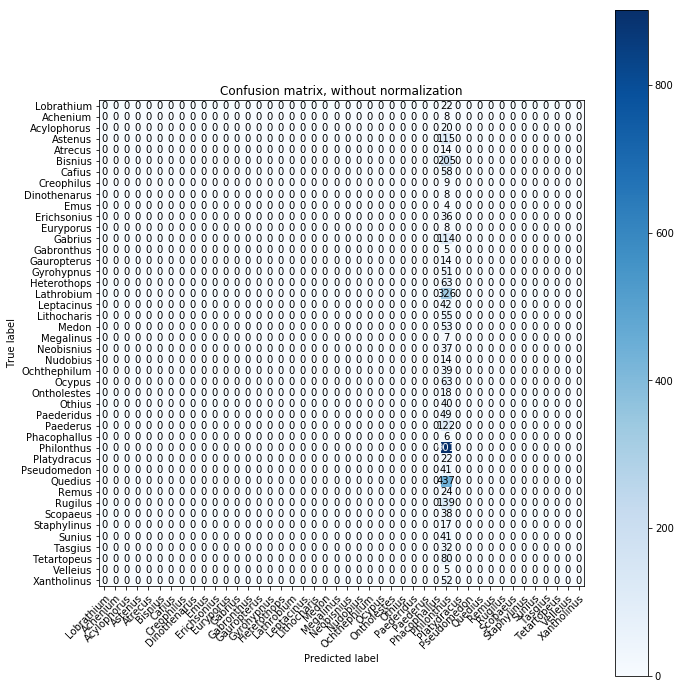

In [76]:
y_true = val_generator.classes
print(y_true)
matplotlib.rcParams['figure.figsize'] = [10, 10]
plot_confusion_matrix(y_true, y_pred, np.array(labels))